### Overview
This notebook imports the **reference** (an annotated scRNA-seq, publicly available dataset [2]), extracts the data and convert them into CSV for the next annotation step (scmap [3]). 

**This notebook is written in Python.**

In [1]:
#Libraries and random state
import scanpy as sc
import pandas as pd
%matplotlib inline 

i_randomstate=4

#### Steps performed

1. Import and inspect the reference dataset

2. Standardize and log-transform the dataset

3. Export the dataset in 4 files:
- expression matrix (transposed to meet requirement in R), 
- gene names, 
- cell ID 
- celltype

4. Calculate the highly expressed genes (HVG)

5. Export the HVG as CSV

In [2]:
#Import annotated scRNA-seq (reference for annotation)
input_path ="../../data/input/AllenBrain_annotated.h5ad"
ref_annotation = sc.read(input_path, cache=True)
ref_annotation

AnnData object with n_obs × n_vars = 4052 × 31053
    obs: 'Allen_celltype', 'Allen_sampleID'

In [3]:
#Check data 
ref_annotation.X

array([[4., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.],
       [2., 0., 0., ..., 0., 0., 0.],
       ...,
       [4., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.],
       [2., 0., 0., ..., 0., 0., 0.]], dtype=float32)

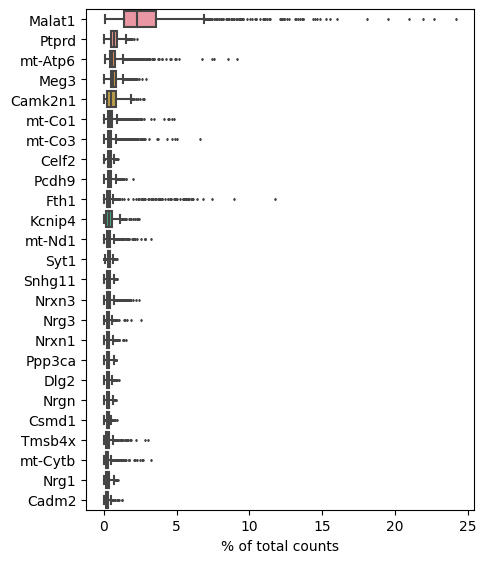

In [4]:
#Visualize the highest expressed genes
sc.pl.highest_expr_genes(ref_annotation, n_top=25)

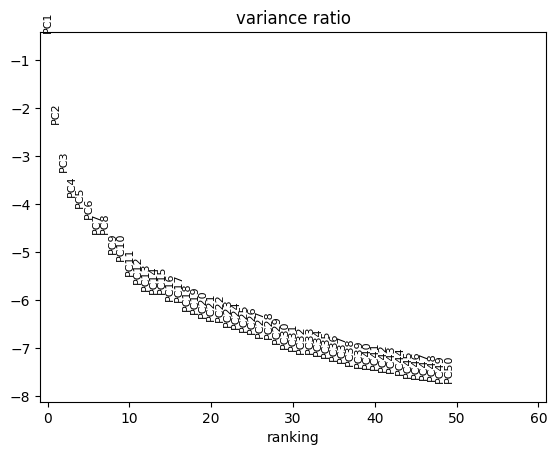

In [5]:
#Visualize the PCA on the data
sc.tl.pca(ref_annotation, svd_solver='arpack')
sc.pl.pca_variance_ratio(ref_annotation, log=True, n_pcs=60)

/home/chiacmm/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


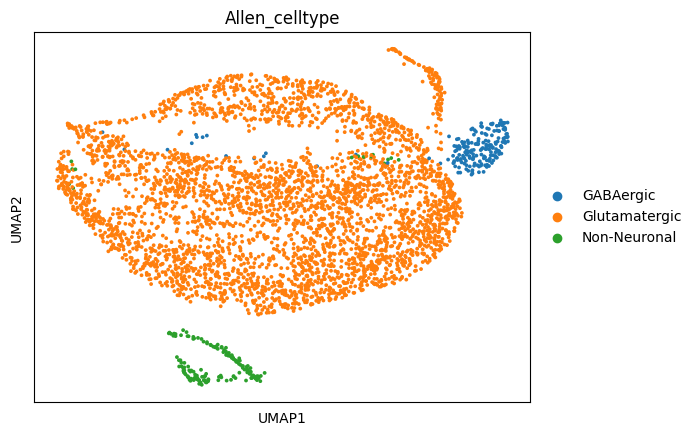

In [6]:
#Visualizing clustering of data per annotated cell-type. 
sc.pp.neighbors(ref_annotation, n_neighbors=40, n_pcs=50, random_state=i_randomstate)
sc.tl.umap(ref_annotation, min_dist=0.4, random_state=i_randomstate)
sc.pl.umap(ref_annotation, color="Allen_celltype")

##### Standardize and log-transform the dataset

In [7]:
#Standardization and log-transformation
sc.pp.normalize_total(ref_annotation, exclude_highly_expressed=True, max_fraction=0.2, inplace=True)
sc.pp.log1p(ref_annotation)

In [8]:
#Check data 
ref_annotation.X

array([[2.041     , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.5176709 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.86355925, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.653904  , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.4225787 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.350507  , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

##### Export dataset as CSV

In [9]:
#Write reference annotation to CSV

#Get expression matrix, gene names, cell_ID and celltype
d_exprs = ref_annotation.X
l_genes = ref_annotation.var_names.tolist()
l_cellID = ref_annotation.obs_names.tolist()
l_celltype = ref_annotation.obs["Allen_celltype"].tolist()


#Create dataframe without index column and column names
df_genes = pd.DataFrame(l_genes)
df_cellID = pd.DataFrame(l_cellID)
df_celltype = pd.DataFrame(l_celltype)
df_exprs = pd.DataFrame(d_exprs)

#Transpose to get columns = cells, rows = genes
df_exprs = df_exprs.transpose()


#Write data
path = "../../data/demo_public/output/ref_lgenes.csv"
df_genes.to_csv(path, sep=',', index=False)

path = "../../data/demo_public/output/ref_lcellID.csv"
df_cellID.to_csv(path, sep=',', index=False)

path = "../../data/demo_public/output/ref_lcelltype.csv"
df_celltype.to_csv(path, sep=',', index=False)

path = "../../data/demo_public/output/ref_exprs.csv"
df_exprs.to_csv(path, sep=',', index=False)

##### Calculate Highly variable genes (HVG)
Seurat_v3 is used here and this method works with raw counts. Thus the unannotated scRNA-seq is re-imported.

In [10]:
#Re-import annotated scRNA-seq (reference for annotation) for hvg calculation
ref_hvg = sc.read(input_path, cache=True)
ref_hvg

AnnData object with n_obs × n_vars = 4052 × 31053
    obs: 'Allen_celltype', 'Allen_sampleID'

In [11]:
#Calculate highly variable genes
sc.pp.highly_variable_genes(ref_hvg, flavor='seurat_v3', n_top_genes=2000, inplace=True) 
ref_hvg

AnnData object with n_obs × n_vars = 4052 × 31053
    obs: 'Allen_celltype', 'Allen_sampleID'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'

##### Export HVG as CSV

In [12]:
#Write to CSV
l_hvg_genes = ref_hvg.var_names[ref_hvg.var["highly_variable"]==True].tolist()

#Create dataframe
df_hvggenes = pd.DataFrame(l_hvg_genes)

#Write data
path = "../../data/demo_public/output/ref_l_hvg_genes.csv"
df_hvggenes.to_csv(path, sep=',', index=False)

##### Reference
1. Chia, C. M., Roig Adam, A., & Moro, A. (2022). *In silico* multiple single-subject neural tissue screening using deconvolution on pseudo-bulk RNA-seq - a prototype. Bioinformatics and Systems Biology joint degree program. Vrije Universiteit Amsterdam and University of Amsterdam. 

2. Allen Institute for Brain Science (2004). Allen Mouse Brain Atlas, Mouse Whole Cortex and Hippocampus 10x. Available from mouse.brain-map.org. Allen Institute for Brain Science (2011).

3. Kiselev, V. Y., Yiu, A., & Hemberg, M. (2018). scmap: projection of single-cell RNA-seq data across data sets. Nature methods, 15(5), 359–362. https://doi.org/10.1038/nmeth.4644